# Utility functions

In [ ]:
import math

def relu(x):

    if isinstance(x, list):
        return [relu(element) for element in x]
    else:
        return max(0, x)

def relu_derivative(x):

    if isinstance(x, list):
        return [relu_derivative(element) for element in x]
    else:
        return 1 if x > 0 else 0

def softmax(logits):
    '''
    use "log-sum-exp trick"
    to prevents overflow.
    '''
    exp_logits = []
    for row in logits:
        max_logit = max(row)  # Find the maximum value in the row
        exp_row = [math.exp(x - max_logit) for x in row]  # Subtract max_logit from each element
        exp_logits.append(exp_row)

    sums = [sum(row) for row in exp_logits]
    return [[x / sums[i] for x in row] for i, row in enumerate(exp_logits)]


def categorical_cross_entropy(predictions, y_true):
    # use "epsilon smoothing" to prevent overflow
    batch_size = len(predictions)
    loss = 0
    epsilon = 1e-9  # A small constant to prevent math domain error

    for i in range(batch_size):
        true_label = y_true[i]
        predicted_prob = predictions[i][true_label]
        if predicted_prob <= 1e-9:
          predicted_prob = predicted_prob + epsilon
        loss -= math.log(predicted_prob)  # Adding epsilon to the predicted probability

    return loss / batch_size

def compute_dL_dout(predictions, y_true):
    """Compute the gradient of the loss with respect to the output (dL_dout).
    Assume in this case that the activation function of the output layer: softmax,
    and the loss is : categorical cross entropy
    """
    batch_size = len(predictions)
    num_classes = len(predictions[0])
    dL_dout = [[0.0 for _ in range(num_classes)] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(num_classes):
            if j == y_true[i]:
                dL_dout[i][j] = (predictions[i][j] - 1) / batch_size
            else:
                dL_dout[i][j] = predictions[i][j] / batch_size

    return dL_dout

def max_index_2d(matrix):
    max_val = -float('inf')
    max_idx = (0, 0)
    for i, row in enumerate(matrix):
        for j, val in enumerate(row):
            if val > max_val:
                max_val = val
                max_idx = (i, j)
    return max_idx

def elementwise_multiplication(a, b):
    """
    Performs element-wise multiplication of two multi-dimensional lists.
    """
    if isinstance(a, list) and isinstance(b, list):
        return [elementwise_multiplication(x, y) for x, y in zip(a, b)]
    else:
        return a * b



In [ ]:
def flatten_4d_list(lst):
    """Flatten a 4D list into a 2D list, preserving the first dimension.
    """
    return [[item for sublist2d in sublist3d for sublist1d in sublist2d for item in sublist1d] for sublist3d in lst]

def reshape_2d_to_4d(lst, shape):
    """Reshape a 2D list into a 4D list with the specified shape, preserving the first dimension.
    """
    depth, rows, cols = shape
    batch = len(lst)  # Infer the batch size from the length of the input list
    reshaped_list = []

    for i in range(batch):
        flat = lst[i]
        reshaped_batch = []
        index = 0

        for d in range(depth):
            layer = []
            for r in range(rows):
                row = flat[index:index + cols]
                layer.append(row)
                index += cols
            reshaped_batch.append(layer)

        reshaped_list.append(reshaped_batch)

    return reshaped_list


# Define the layers

In [ ]:
import random

class ConvLayer:
    def __init__(self, filter_size, num_filters, num_channels, stride=1, padding=0):
        self.filters = self.initialize_filters(filter_size, num_filters, num_channels)
        self.stride = stride
        self.padding = padding

    # Initialize weights, utilizing Xavier initialization
    def initialize_filters(self,filter_size, num_filters, num_channels):
        weights = []
        for _ in range(num_filters):
            filter_weights = []
            for _ in range(num_channels):
                channel_weights = []
                for _ in range(filter_size):
                    row_weights = []
                    for _ in range(filter_size):
                        row_weights.append(random.gauss(0, 1) / (filter_size * filter_size * num_channels) ** 0.5)
                    channel_weights.append(row_weights)
                filter_weights.append(channel_weights)
            weights.append(filter_weights)
        return weights

    def pad_4d_array(self, array, pad_size): # the padded value is all 0
        batch_size, channels, height, width = len(array), len(array[0]), len(array[0][0]), len(array[0][0][0])
        pad_h, pad_w = pad_size
        padded_array = [[[[0 for _ in range(width + 2 * pad_w)] for _ in range(height + 2 * pad_h)] for _ in range(channels)] for _ in range(batch_size)]
        for b in range(batch_size):
            for c in range(channels):
                for i in range(height):
                    for j in range(width):
                        padded_array[b][c][i + pad_h][j + pad_w] = array[b][c][i][j]
        return padded_array

    def forward(self, input):
        self.input = self.pad_4d_array(input, (self.padding, self.padding))  # add padding to input
        batch_size, channels, h, w = len(self.input), len(self.input[0]), len(self.input[0][0]), len(self.input[0][0][0])
        f = len(self.filters[0][0])
        out_h = (h - f) // self.stride + 1
        out_w = (w - f) // self.stride + 1
        self.output = [[[[0 for _ in range(out_w)] for _ in range(out_h)] for _ in range(len(self.filters))] for _ in range(len(input))]

        for sample_idx, sample in enumerate(self.input):
            for i in range(out_h):
                for j in range(out_w):
                    for filter_idx, filt in enumerate(self.filters):
                        result = 0
                        for c in range(channels):
                            for x in range(f):
                                for y in range(f):
                                    result += sample[c][i * self.stride + x][j * self.stride + y] * filt[c][x][y]
                        self.output[sample_idx][filter_idx][i][j] = result
        return self.output

    def backward(self, dL_dout, learning_rate):
        batch_size, channels, h, w = len(self.input), len(self.input[0]), len(self.input[0][0]), len(self.input[0][0][0])
        f = len(self.filters[0][0])
        out_h = len(dL_dout[0][0])
        out_w = len(dL_dout[0][0][0])

        dL_dfilters = [[[[0 for _ in range(f)] for _ in range(f)] for _ in range(channels)] for _ in range(len(self.filters))]
        dL_dinput = [[[[0 for _ in range(w)] for _ in range(h)] for _ in range(channels)] for _ in range(batch_size)]

        for sample_idx, dL_dout_sample in enumerate(dL_dout):
            for i in range(out_h):
                for j in range(out_w):
                    for filter_idx, filt in enumerate(self.filters):
                        for c in range(channels):
                            for x in range(f):
                                for y in range(f):
                                    input_x = i * self.stride + x
                                    input_y = j * self.stride + y
                                    dL_dfilters[filter_idx][c][x][y] += dL_dout_sample[filter_idx][i][j] * self.input[sample_idx][c][input_x][input_y]
                                    dL_dinput[sample_idx][c][input_x][input_y] += dL_dout_sample[filter_idx][i][j] * filt[c][x][y]

        for filter_idx in range(len(self.filters)):
            for c in range(len(self.filters[filter_idx])):
                for x in range(len(self.filters[filter_idx][c])):
                    for y in range(len(self.filters[filter_idx][c][x])):
                        self.filters[filter_idx][c][x][y] -= learning_rate * dL_dfilters[filter_idx][c][x][y]

        if self.padding > 0:
            dL_dinput = [[dL_dinput[sample_idx][c][self.padding:-self.padding][self.padding:-self.padding] for c in range(channels)] for sample_idx in range(batch_size)]

        return dL_dinput


class MaxPoolLayer:
    def __init__(self, size):
        self.size = size  # In this code, stride = size of pooling filter

    def forward(self, input):
        self.input = input
        n, c, h, w = len(input), len(input[0]), len(input[0][0]), len(input[0][0][0])
        new_h = h // self.size
        new_w = w // self.size
        self.output = [[[[0 for _ in range(new_w)] for _ in range(new_h)] for _ in range(c)] for _ in range(n)]
        for sample_idx, sample in enumerate(input):
            for channel_idx, channel in enumerate(sample):
                for i in range(new_h):
                    for j in range(new_w):
                        patch = [[channel[i*self.size + x][j*self.size + y] for y in range(self.size)] for x in range(self.size)]
                        self.output[sample_idx][channel_idx][i][j] = max(max(row) for row in patch)
        return self.output


    def backward(self, dL_dout):
      n, c, h, w = len(self.input), len(self.input[0]), len(self.input[0][0]), len(self.input[0][0][0])
      dL_dinput = [[[[0 for _ in range(w)] for _ in range(h)] for _ in range(c)] for _ in range(n)]
      new_h = h // self.size
      new_w = w // self.size

      for sample_idx, dL_dout_sample in enumerate(dL_dout):
          for channel_idx, dL_dout_channel in enumerate(dL_dout_sample):
              for i in range(new_h):
                  for j in range(new_w):
                      patch = [[self.input[sample_idx][channel_idx][i*self.size + x][j*self.size + y] for y in range(self.size)] for x in range(self.size)]
                      max_i, max_j = max_index_2d(patch)
                      dL_dinput[sample_idx][channel_idx][i*self.size + max_i][j*self.size + max_j] = dL_dout_channel[i][j]

      return dL_dinput


# Fully connected layer
class FullyConnectedLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = self.initialize_weights(input_dim, output_dim)
        self.biases = [0 for _ in range(output_dim)]

    # Initialize weights, utilizing Xavier initialization
    def initialize_weights(self, input_dim, output_dim):
      weights = []
      for _ in range(input_dim):
          row = []
          for _ in range(output_dim):
              row.append(random.gauss(0, 1) / (input_dim ** 0.5))
          weights.append(row)
      return weights

    def forward(self, input):
        self.input = input
        output = []
        for row in input:
            output_row = []
            for j in range(len(self.weights[0])):  # Loop over output dimensions
                sum1 = sum(row[i] * self.weights[i][j] for i in range(len(row))) + self.biases[j]
                output_row.append(sum1)
            output.append(output_row)
        self.output = output
        return self.output

    def backward(self, dL_dout, learning_rate):
        dL_dinput = []
        for dL_dout_row in dL_dout:
            dL_dinput_row = []
            for weight_row in self.weights:
                dL_dinput_row.append(sum(dL_dout_row[i] * weight_row[i] for i in range(len(dL_dout_row))))
            dL_dinput.append(dL_dinput_row)

        # Gradient of loss with respect to weights
        dL_dweights = [[0 for _ in range(len(self.weights[0]))] for _ in range(len(self.weights))]
        for i in range(len(self.input)):
            for j in range(len(self.input[0])):
                for k in range(len(dL_dout[0])):
                    dL_dweights[j][k] += self.input[i][j] * dL_dout[i][k]

        # Gradient of loss with respect to biases
        dL_dbiases = [0 for _ in range(len(self.biases))]
        for i in range(len(dL_dout)):
            for j in range(len(dL_dout[0])):
                dL_dbiases[j] += dL_dout[i][j]

        # Update weights and biases
        for i in range(len(self.weights)):
            for j in range(len(self.weights[0])):
                self.weights[i][j] -= learning_rate * dL_dweights[i][j]

        for i in range(len(self.biases)):
            self.biases[i] -= learning_rate * dL_dbiases[i]

        return dL_dinput



# Define architecture

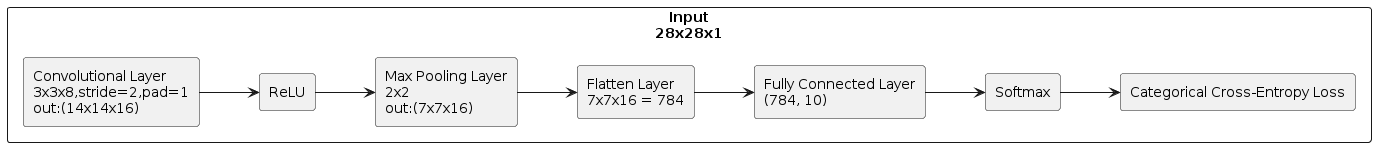

In [ ]:
class SimpleCNN:
    def __init__(self):
        self.conv = ConvLayer(3, 16,1, 2,1) # input size 28x28x1, output 14x14x16 ( 14 = (28-3+2) //2+1)
        self.pool = MaxPoolLayer(2) # ouput size 7x7x16
        self.fc = FullyConnectedLayer(16 * 7 * 7, 10)  # MNIST has 10 classes

    def forward(self, input):
        out = self.conv.forward(input)
        out = relu(out)
        out = self.pool.forward(out)
        out = flatten_4d_list(out)
        out = self.fc.forward(out)
        out = softmax(out)
        return out

    def backward(self, dL_dout, learning_rate):
        dL_dout = self.fc.backward(dL_dout, learning_rate)
        dL_dout = reshape_2d_to_4d(dL_dout, (16, 7, 7))
        dL_dout = self.pool.backward(dL_dout)
        dL_dout = elementwise_multiplication(dL_dout, relu_derivative(self.conv.output))
        dL_dout = self.conv.backward(dL_dout, learning_rate)

In [ ]:
import matplotlib.pyplot as plt

def argmax(lst):
    """Helper function to find the index of the maximum element."""
    return max(range(len(lst)), key=lambda i: lst[i])

def accuracy(predictions, targets):
    """Calculate the accuracy of the predictions compared to the targets."""
    pred_classes = [argmax(pred) for pred in predictions]

    correct = 0
    for pred, true in zip(pred_classes, targets):
        if pred == true:
            correct += 1

    return correct / len(pred_classes)

def train(network, X_train, y_train, X_val, y_val, epochs, learning_rate):

    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        # Forward pass and training loss
        output_train = network.forward(X_train)
        train_loss = categorical_cross_entropy(output_train, y_train)
        training_losses.append(train_loss)

        # Compute gradients and update weights
        dL_dout = compute_dL_dout(output_train, y_train)
        network.backward(dL_dout, learning_rate)

        # Training accuracy
        train_acc = accuracy(output_train, y_train)
        training_accuracies.append(train_acc)

        # Validation loss and accuracy
        output_val = network.forward(X_val)
        val_loss = categorical_cross_entropy(output_val, y_val)
        validation_losses.append(val_loss)

        val_acc = accuracy(output_val, y_val)
        validation_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Plot the loss and accuracy curves
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_losses, label='Training Loss')
    plt.plot(epochs_range, validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()




In [ ]:
def predict(network, X):
  output = network.forward(X)
  predictions = [row.index(max(row)) for row in output]
  return predictions

def evaluate(network, X, y):
    predictions = predict(network, X)
    print(classification_report(y, predictions))

# Test with Mnist

In [ ]:
# Load and preprocess MNIST data
def load_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28) / 255.0
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28) / 255.0
    return (X_train, y_train), (X_test, y_test)

Epoch 1, Train Loss: 2.3035, Train Acc: 0.1333, Val Loss: 2.2000, Val Acc: 0.2200
Epoch 2, Train Loss: 2.2184, Train Acc: 0.2033, Val Loss: 2.1481, Val Acc: 0.3000
Epoch 3, Train Loss: 2.1450, Train Acc: 0.3367, Val Loss: 2.0979, Val Acc: 0.3000
Epoch 4, Train Loss: 2.0768, Train Acc: 0.4800, Val Loss: 2.0482, Val Acc: 0.4400
Epoch 5, Train Loss: 2.0113, Train Acc: 0.5500, Val Loss: 1.9986, Val Acc: 0.4600
Epoch 6, Train Loss: 1.9473, Train Acc: 0.6233, Val Loss: 1.9491, Val Acc: 0.4800
Epoch 7, Train Loss: 1.8840, Train Acc: 0.6500, Val Loss: 1.8995, Val Acc: 0.5600
Epoch 8, Train Loss: 1.8212, Train Acc: 0.6967, Val Loss: 1.8502, Val Acc: 0.6200
Epoch 9, Train Loss: 1.7588, Train Acc: 0.7100, Val Loss: 1.8011, Val Acc: 0.6600
Epoch 10, Train Loss: 1.6968, Train Acc: 0.7400, Val Loss: 1.7525, Val Acc: 0.6600
Epoch 11, Train Loss: 1.6352, Train Acc: 0.7500, Val Loss: 1.7046, Val Acc: 0.6600
Epoch 12, Train Loss: 1.5742, Train Acc: 0.7833, Val Loss: 1.6575, Val Acc: 0.6800
Epoch 13, Tra

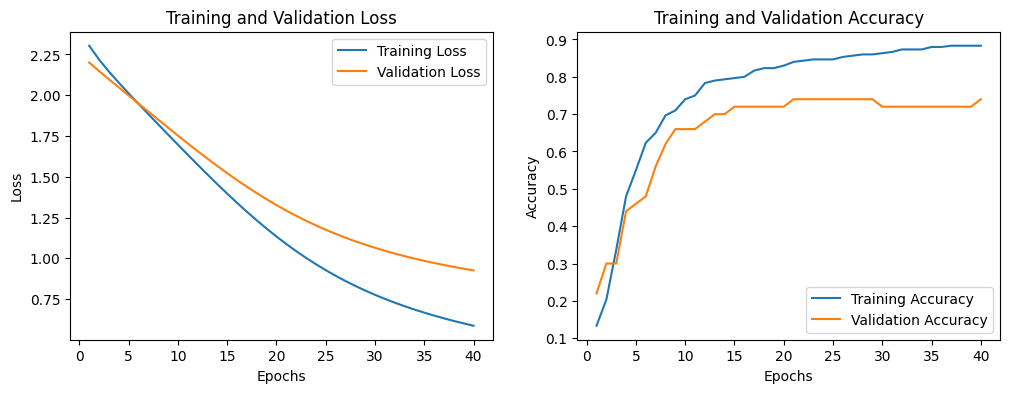

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        15
           2       1.00      0.70      0.82        10
           3       0.80      1.00      0.89         8
           4       0.92      0.61      0.73        18
           5       0.83      0.45      0.59        11
           6       0.70      1.00      0.82         7
           7       1.00      0.88      0.93         8
           8       0.67      0.57      0.62         7
           9       0.38      1.00      0.55         6

    accuracy                           0.78       100
   macro avg       0.81      0.80      0.77       100
weighted avg       0.84      0.78      0.78       100



In [ ]:
from keras.datasets import mnist
from sklearn.metrics import classification_report

# Example usage with MNIST data

(X_train, y_train), (X_test, y_test) = load_mnist()

network = SimpleCNN()
train(network, X_train[200:500], y_train[200:500],X_train[1000:1050], y_train[1000:1050], epochs=40, learning_rate=0.07)

evaluate(network, X_test[700:800], y_test[700:800])


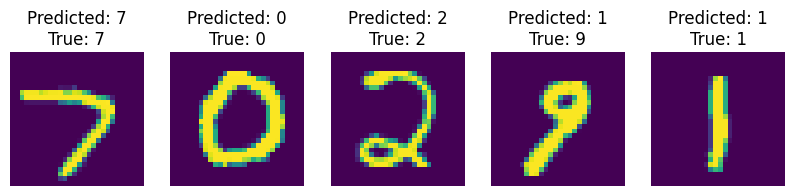

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_images_with_predictions(model, images, true_labels, class_names):
    num_images = len(images)
    predicted_labels = predict(model, images)

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    if num_images == 1:
        axes = [axes]  # make it iterable

    # Display each image along with its predicted label
    for i, ax in enumerate(axes):
        ax.imshow(np.squeeze(images[i]), cmap='gray' if images[i].ndim == 2 else None)
        ax.set_title(f"Predicted: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}")
        ax.axis('off')

    plt.show()


display_images_with_predictions(network, X_test[70:75], y_test[70:75], [str(i) for i in range(10)])
